# DUVET Overview
**D**anish **UV** **E**nd-station **T**ool

This tool is designed to help you manage data obtained at the AU-UV endstation of the ASTRID2 synchrotron at Aarhus Univeristy, in Denmark.
Its current main functionality is to read the data files produced by the endstation, calculate absorbances, and produce plots of absorbance.
It can also fit the absorbance data with gaussian functions as a first step in your data analysis.

## Dependencies

To use DUVET you must have python version 3.12.3 or higher.


DUVET relies on several python packages, most of which are very standard for python data analysis workflows. They are listed below, along with the version I am running in my own development environment. But I expect the latest versions of each to be compatible.

- **numpy** (version 1.26.4)
- **pandas** (version 2.2.2)
- **matplotlib** (version 3.8.4)
- **serial** (version 0.0.97)
- **scipy** (version 1.13.1)
- **PyQt5** (version 5.15.9)
- **pyqtgraph** (version 0.13.7)
- **pyqt_color_picker** (version 0.0.20)

# Reading, Calibrating, and Displaying Spectra

The tools for working with spectral data are all in the `specTools` module, which is located inside the `Tools` folder. If your working directory is the main directory of DUVET (i.e., you have duvet.py in the same folder as your current workbook or program), you can import specTools as follows:

In [1]:
import sys
sys.path.insert(0, 'Tools')
import specTools
#help(specTools)

You can run `help(specTools)` to see a full summary of the classes and methods. 

## Example: Reading Data

To read data, you need to know the paths to your relevant samples and backgrounds. You can have as many samples and backgrounds as you want, and they will be averaged together. For this example, I have two. 

In [2]:
# keep things reproducable by setting the random seed.
import random
random.seed(31415)

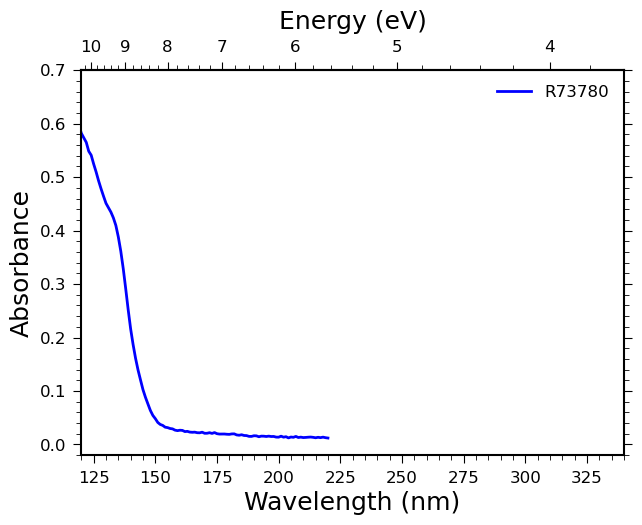

In [3]:
path = "./raw_data/SergioIoppolo-November2023/20231101/"

bkgd_short1 = path + "R73773.d01"
bkgd_short2 = path + "R73773.d02"
sample_short1 = path + "R73780.d01"
sample_short2 = path + "R73780.d02"

# build the spectrum object
spec1 = specTools.Spectrum()
spec1.change_name("R73780")
# add backgrounds
spec1.add_bkgd(bkgd_short1)
spec1.add_bkgd(bkgd_short2)
# add samples
spec1.add_sample(sample_short1)
spec1.add_sample(sample_short2)
# give it a color (is black by default)
spec1.change_color("blue")
# average the scans together
spec1.average_scans()

# make a plot of the data
specTools.plot_absorbance([spec1], figsize=(7, 5),
                      xlim=(120, 340), ylim=(-0.02, 0.7),
                      save_path="./misc_figures/one_spectrum.svg");

By running `help` on the `Spectrum` object you can see all its methods:

In [4]:
help(spec1)

Help on Spectrum in module specTools object:

class Spectrum(builtins.object)
 |  Spectrum(debug=False, datapath=None)
 |
 |  Represents a spectrum, so the average of one or more scans
 |
 |  Parameters belonging to the fully constructed object:
 |
 |      baseline_p : (list) parameters from the fit of the rayleigh scattering
 |                   baseline. None until subtract_baseline() has been run.
 |      bkgd : (pandas.DataFrame) The averaged background data.
 |      bkgds : (list) a list of SingleSpectrum objects that make up
 |              the backgrounds.
 |      changelog : (str) a string which contains the history of the data. Every
 |                  time a function is called, a line is written to describe
 |                  what happened and at what time. This is then added to the
 |                  header of a file during export.
 |      cindex : (int) the index of the current position in the color cycle for
 |               color cycling.
 |      color : (str) the hex 

`Spectrum` objects have several attributes. Below are the attributes of the one we just constructed.

In [5]:
spec1.name

'R73780'

In [6]:
spec1.color

'blue'

In [7]:
# these are the calibrated data which are used for plotting and fitting
spec1.data

,absorbance,wavelength
index,,
0,-0.149512,110.0
1,-0.169499,111.0
2,-0.112865,112.0
3,-0.218492,113.0
4,-23.447676,114.0
...,...,...
106,0.013420,216.0
107,0.012746,217.0
108,0.013698,218.0


In [8]:
# this is a value which can control a shift in absorbance of the data for
# plotting. More details on offsets are below
spec1.offset

0.0

In [9]:
# this controls if this spectrum is visible in plotting or not. This is not so
# useful when working in jupyter notebook or other code interfaces, but very
# useful in a GUI where you can use checkboxes to control what is plotted.
spec1.visible

True

In [10]:
# a list of the backgrounds associated with this Spectrum
spec1.bkgds

In [11]:
# a list of the samples associated with this Spectrum
spec1.samples

As you can see above, printing the `bkgds` and `samples` attributes of the spectrum object gives a strange output. This is because `specTools` configures your individual scan data with `SingleSpectrum` objects. These are discussed in more detail later.

## Example: Plotting Data

Above, we plotted one spectrum in blue. But the `plot_absorbance` function is designed for plotting several spectra if we want to. In this example, we build a second `Spectrum` object and plot its data alongside the one we made previously. Note that `plot_absorbance` takes a list of `Spectrum` objects to plot. This list can be as long as you like.

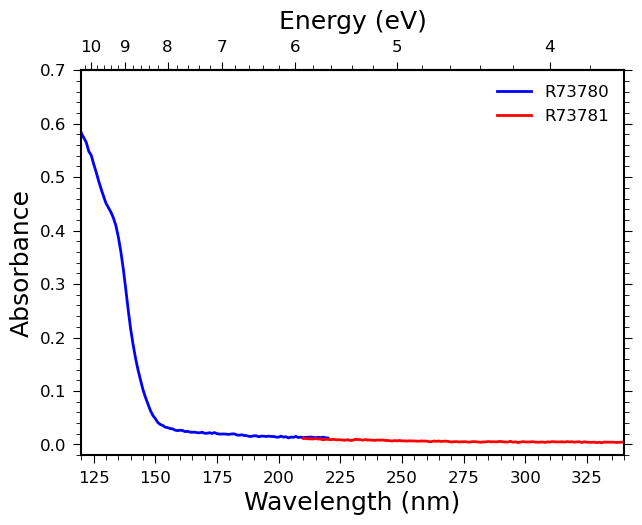

In [12]:
bkgd_long1 = path + "R73775.d01"
bkgd_long2 = path + "R73775.d02"
sample_long1 = path + "R73781.d01"
sample_long2 = path + "R73781.d02"

# build long spectrum
spec2 = specTools.Spectrum()
spec2.change_name("R73781")
spec2.add_bkgd(bkgd_long1)
spec2.add_bkgd(bkgd_long2)
spec2.add_sample(sample_long1)
spec2.add_sample(sample_long2)
spec2.change_color("red")
spec2.average_scans()

specTools.plot_absorbance([spec1, spec2], figsize=(7, 5),
                      xlim=(120, 340), ylim=(-0.02, 0.7),
                      save_path="./misc_figures/two_spectrums.svg");

## Example: Shifting Spectrums

The spectra are not perfectly aligned. This happens normally with the endstation due to a variety of factors, and we can apply offsets when plotting to correct for this. For example below, we change the offset on the longer wavelength spectrum upwards by 0.1:

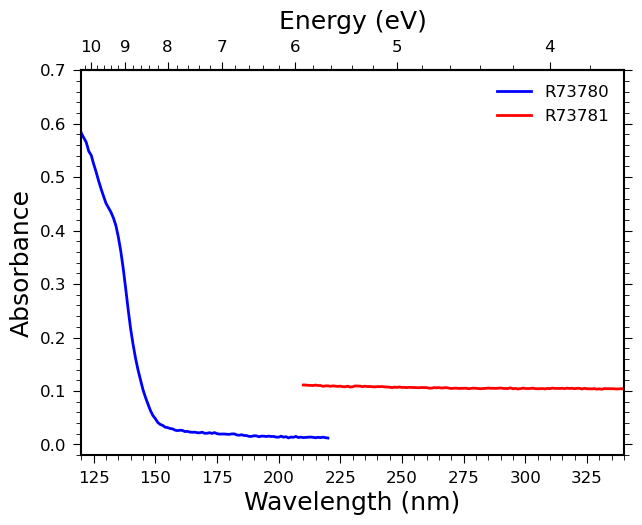

In [13]:
spec2.change_offset(0.1)

specTools.plot_absorbance([spec1, spec2], figsize=(7, 5),
                      xlim=(120, 340), ylim=(-0.02, 0.7),
                      save_path="./misc_figures/shift_example.svg");

A new column in the `data` attribute dataframe will show the offset absorbance:

In [14]:
spec2.data

,absorbance,wavelength,offset absorbance
index,,,
0,0.011248,210.0,0.111248
1,0.011132,211.0,0.111132
2,0.010637,212.0,0.110637
3,0.010427,213.0,0.110427
4,0.010252,214.0,0.110252
...,...,...,...
126,0.004211,336.0,0.104211
127,0.003718,337.0,0.103718
128,0.004022,338.0,0.104022


Calling the `change_offset` function always changes the offset with respect to the data's original absorbance values, not the offset values. If we call it again and pass 0.0 as our offset value, the data in the plot return to where they were originally (the offset is now set to 0, rather than having 0 added to it):

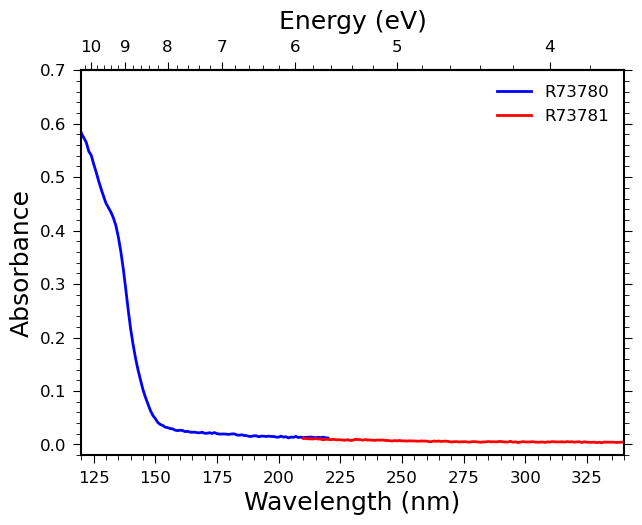

In [15]:
spec2.change_offset(0.0)

specTools.plot_absorbance([spec1, spec2], figsize=(7, 5),
                      xlim=(120, 340), ylim=(-0.02, 0.7),
                      save_path="./misc_figures/shift_example_2.svg");

## Example: Stitching Spectra

Properly aligned spectra can be stitched together into a single object. This is done by creating a `SitchedSpectrum` which consists of two or more `Spectrum` objects. The `Spectrum` objects are passed to the `StitchedSpectrum` initializer in a list. There can be as many `Spectrum` objects in that list as you need, so you can stitch many spectra together at once. Below is an example where we stitch the two spectra we already made above:

Note! You must first align your spectra by changing one's offset before stitching. A previous version of the stitching algorithm did this for you, but that has been depreciated.

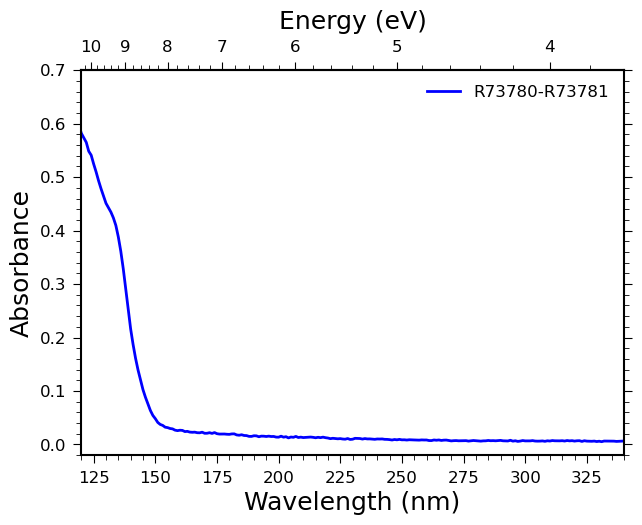

In [16]:
spec2.change_offset(0.002)
stitched = specTools.StitchedSpectrum([spec1, spec2])

specTools.plot_absorbance([stitched], figsize=(7, 5),
                      xlim=(120, 340), ylim=(-0.02, 0.7),
                      save_path="./misc_figures/stitched.svg");

In [17]:
stitched.name

'R73780-R73781'

In [18]:
stitched.visible

True

In [19]:
stitched.color

'blue'

In [20]:
stitched.offset

0

In [21]:
stitched.samples

In [22]:
stitched.bkgds

## Additional Information on the Stitching Algorithm

The stitching algorithm can do more than just join adjacent spectra. It was also designed to be able to splice higher resolution spectra into other, wider wavelength range spectra. It can stitch any arbitrary number of spectra at any arbitrary wavelength ranges

It operates by iterating through every wavelength point of every spectrum you provide it. At each point, it asks itself "do we already have data at this wavelength in the resultant stitched spectrum we are building?" If the answer is no, the algorithm will add that wavelength and its absorbance value to the resultant stitched spectrum. If the answer is yes, the algorithm will compare the value it already has at that wavelength to the "new" value from the spectrum it is currently looking at. If the new value was taken from a spectrum with higher resolution than the current value's spectrum, it will replace the current value with the new value. If the values were taken using the same resolution, it will check how many samples were taken in each value's spectrum. The value with a higher sample count (i.e. better signal to noise) will be chosen. 

This process prioritizes high resolution spectra, then high sample number spectra, then all other spectra. The result will be a combined spectrum using the highest available resolution and signal to noise at each wavelength range provided to it.

It does not perform any value averaging. If you, like in the above example, have two adjacent spectra taken with the same resolution and number of samples with some wavelength overlap, the stitching algorithm will use the values from the first spectrum in the list provided to it, and switch to the next spectrum when it sees data at wavelengths not in the first spectrum. It does not consider any possible offsets between the spectra, and it does not attempt to average together values in the overlapping region. If that is the behavior you want in your data reduction, you will have to do it yourself.

## Example: Changing Names

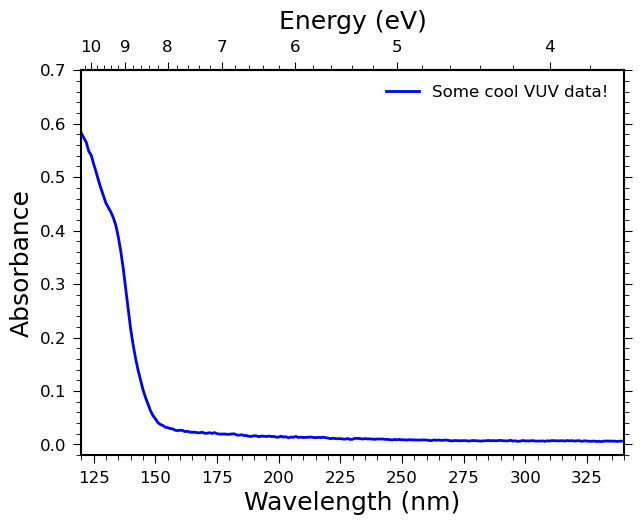

In [23]:
stitched.change_name("Some cool VUV data!")

specTools.plot_absorbance([stitched], figsize=(7, 5),
                      xlim=(120, 340), ylim=(-0.02, 0.7),
                      save_path="./misc_figures/name_change.svg");

## Example: Changing Colors

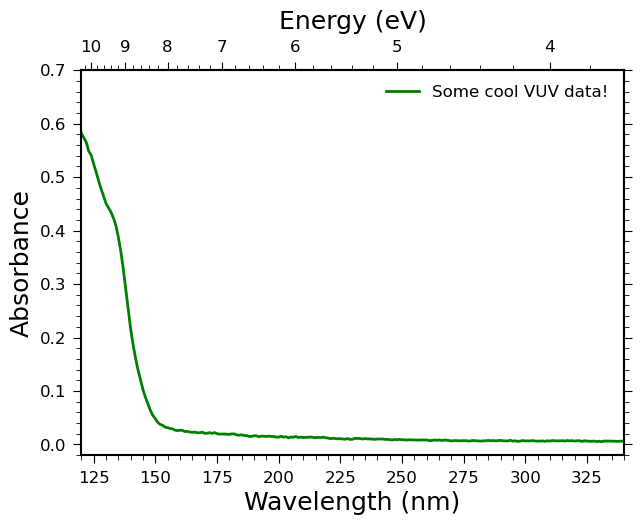

In [24]:
stitched.change_color("green")

specTools.plot_absorbance([stitched], figsize=(7, 5),
                      xlim=(120, 340), ylim=(-0.02, 0.7),
                      save_path="./misc_figures/color_change.svg");

## Example: Simple Baseline Subtraction

For the baseline subtraction, the minimum value is found in some wavelenght range passed to the function. The entire absorbance data are then shifted such that the minimum is at zero.

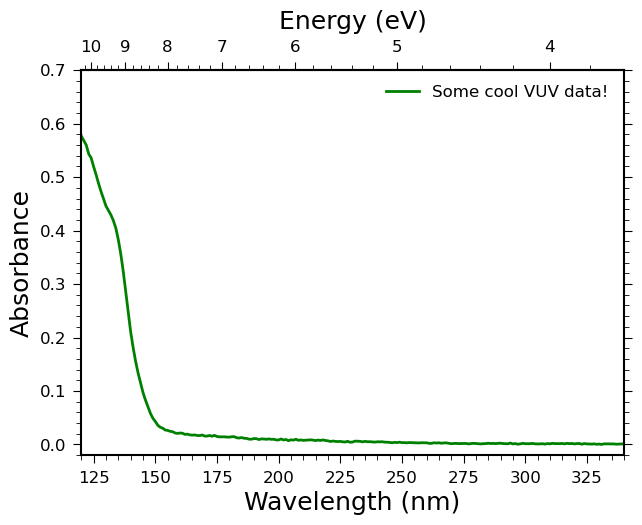

In [25]:
stitched.subtract_baseline(lim=(120, 340))

specTools.plot_absorbance([stitched], figsize=(7, 5),
                      xlim=(120, 340), ylim=(-0.02, 0.7),
                      save_path="./misc_figures/baseline_subtract.svg");

## `SingleSpectrum` Objects

In order to make many of the user-interface features easier to program, `specTools` stores the data from your individual data scan files (i.e. those ending in .d01, .d02, etc) in `SingleScan` objects. Each such object represents one scan, hence the name! They do not distinguish between backgrounds and samples - that is done at the level of the `Spectrum` object.

We can have a look at one of the `SingleScan`s that was created in the background earlier:

In [26]:
this_singleScan = spec1.bkgds[0]
this_singleScan.data

,Lambda,Keith/nA,Ch1/volts,Ch2/volts,Ch3/volts,Z_Motor,Beam_current,temperature,GC_Pres,Time,UBX_x,UBX_y,nor_signal,wavelength,av_signal
0,110.0,-0.00049,-0.00058,0.0006,-0.0001,-12.6822,180.0957,-50.16,0.0,10:49:09,-0.002211,-0.001252,-0.000490,110.0,-0.000490
1,111.0,-0.00070,-0.00058,0.0006,-0.0001,-12.4759,180.0224,-50.16,0.0,10:49:11,-0.002494,-0.001280,-0.000700,111.0,-0.000700
2,112.0,-0.00061,-0.00058,0.0006,-0.0001,-12.2696,179.9491,-50.16,0.0,10:49:14,-0.002488,-0.001270,-0.000610,112.0,-0.000610
3,113.0,-0.00057,-0.00058,0.0006,-0.0001,-12.0632,179.8666,-50.16,0.0,10:49:16,-0.002325,-0.001573,-0.000570,113.0,-0.000570
4,114.0,0.00296,-0.00058,0.0007,-0.0001,-11.8568,182.7076,-50.16,0.0,10:49:38,-0.002308,-0.001689,0.002916,114.0,0.002916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,216.0,1.55973,-0.00057,0.0006,-0.0001,9.5375,183.4408,-50.12,0.0,10:54:41,-0.002736,-0.001790,1.530474,216.0,1.530474
107,217.0,1.53702,-0.00057,0.0006,-0.0001,9.7506,183.3675,-50.12,0.0,10:54:43,-0.002338,-0.001720,1.508793,217.0,1.508793
108,218.0,1.51776,-0.00057,0.0006,-0.0001,9.9638,183.3033,-50.16,0.0,10:54:46,-0.002471,-0.001617,1.490409,218.0,1.490409
109,219.0,1.49952,-0.00057,0.0006,-0.0001,10.1770,183.2117,-50.12,0.0,10:54:48,-0.002172,-0.001392,1.473233,219.0,1.473233


In [27]:
this_singleScan.fname

'./raw_data/SergioIoppolo-November2023/20231101/R73773.d01'

You can see that the `.data` attribute of this `SingleScan` object is all the same data as in the file `R73773.d01` we used earlier, as one of the backgrounds of `spec1`.

All of the other functions and attributes of a `SingleScan` object are related to plotting within the "edit spectrum" windows of DUVET's graphical interface and not relevant for this tutorial.

In [28]:
help(this_singleScan)

Help on SingleScan in module specTools object:

class SingleScan(builtins.object)
 |  SingleScan(fname, df=None, debug=False)
 |
 |  Represents a single scan.
 |
 |  Parameters belonging to the fully constructed object:
 |
 |  cindex : (int) the current index in color cycling
 |  cmap : (matplotlib.pyplot.colormap) the colormap for color cycling
 |  color : (str) the HEX code of the scan color for plotting
 |  data : (pandas.dataframe) the data contained in this scan's file
 |  debug : (boolean) whether or not to print debug statements. Defaults to
 |          False.
 |  fname : (str) the full file path associated with this object.
 |  lenccycle (int) the length of the color cycle for color cycling
 |  name : (str) the name of this scan
 |  visible : (boolean) whether or not to show this scan in plotting
 |
 |  Methods defined here:
 |
 |  __init__(self, fname, df=None, debug=False)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  cycle_color(self)
 |      

# Fitting

DUVET includes a robust fit function which can handle gaussian fitting, rayleigh scattering, and custom fit components. This section provides the details on each of these fitting types, which can be used concurrently or separately.

But first, it is worth presenting the entire, formal fit function so that we can label our fit parameters. The function contains three terms: one for each of the possible component types (Gaussian functions, custom components, and Rayleigh scattering). The function is shown below:

$$
f(\lambda) = \sum_{i=1}^{n_g} \frac{a_i}{\sqrt{2\pi}\sigma_i} e^{-\frac{1}{2}\left(\frac{\lambda-\lambda_{0, i}}{\sigma_i}\right)^2} + \sum_{j=1}^{n_{cc}}\alpha_{j} C_{j}\left(\lambda\right) + k\ln\left(\frac{1}{1-\frac{m}{\lambda^4}}\right) + b
$$

where:
- $\lambda$ is the wavelength of the light in the spectrum
- $n_g$ is the number of Gaussian functions to fit with
- $a_i$ is the amplitude of each respective Gaussian function
- $\sigma_i$ is the standard deviation of each respective Gaussian function
- $\lambda_{0, i}$ is the central wavelength of each respective Gaussian function
- $n_{cc}$ is the number of custom components included in the fit
- $\alpha_j$ is the amplitude of each respective custom component
- $C_{j}\left(\lambda\right)$ is the respective custom component in the fit, expressed as an array of absorbance numbers with respect to wavelength
- $m$ describes the loss in transmittance due to the scattering
- $k$ is the amplitude of the Rayleigh scattering baseline
- $b$ is a constant absorbance baseline

DUVET automatically adjusts this function to include as many Gaussian functions and/or custom components as the user specifies. All of the parts of the fit function are optional. If the user specifies to use 0 Gaussian functions, that term will be ignored. If the user does not provide custom components to fit with, that term will be ignored. And Rayleigh scattering is not fit by default, and will be ignored unless the user turns it on. The user enables and disables parts of the fit function by providing arguments to the `fit_peaks` Python function of the `Spectrum` and `StitchedSpectrum` classes of the `specTools` module.

The free parameters which are fit with the function are:
- $a_i$ is the amplitude of each respective Gaussian function
- $\sigma_i$ is the standard deviation of each respective Gaussian function
- $\lambda_{0, i}$ is the central wavelength of each respective Gaussian function
- $\alpha_j$ is the amplitude of each respective custom component
- $k$ is the amplitude of the Rayleigh scattering baseline
- $m$ describes the loss in transmittance due to the scattering
- $b$ is a constant absorbance baseline

The user can optionally provide guesses to the values of these parameters. This is done by providing a list of dictionaries to the `fit_peaks` function. Each dictionary in the list corresponds to one parameter. It must include a lower limit value, a guess value, and an upper limit value.

It is important to provide the guesses in the same order as DUVET expects them. Guesses relating to the custom component amplitudes must be provided first. If no custom components are used, no guesses need to be provided to them. Second must come the guesses relating to the rayleigh scattering, in this order: $m$, $k$, $b$. Third are the guesses for the Gaussian functions. They must be given in groups of three, with each group containing $a$, $\lambda_0$, and $\sigma$ in that order.

Examples of the fitting are shown below:

## Example: Fitting with gaussians

You can fit with any arbitrary number of gaussians. If you provide your own guesses, you can only fit up to the number of functions you provide guesses for. Otherwise, you can fit as many gaussians as you want. However, the program will choose the fit with the best reduced chi square, which tends to prefer smaller numbers of free parameters.

In [29]:
import specTools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# keep things reproducable
random.seed(31415)
# define colors for plotting
colors = ["#dcdcdc", "#2f4f4f", "#a52a2a", "#191970", "#006400", "#bdb76b", "#9acd32",
"#66cdaa", "#ff0000", "#ff8c00", "#ffd700", "#c71585", "#0000cd", "#00ff00",
"#00fa9a", "#00bfff", "#ff00ff", "#dda0dd", "#7b68ee", "#ffa07a"]

def build_spectra(path, bkgd_short1, bkgd_short2, bkgd_long1, bkgd_long2,
                  sample_short1, sample_short2, sample_long1, sample_long2,
                  color="#000001", name=None):
    """
    Builds the spectra as appropriate for this experiment
    """
    # build short spectrum
    spec1 = specTools.Spectrum()
    spec1.change_name(sample_short1[-9:-4])
    spec1.add_bkgd(bkgd_short1)
    spec1.add_bkgd(bkgd_short2)
    spec1.add_sample(sample_short1)
    spec1.add_sample(sample_short2)
    spec1.change_color(color)
    spec1.change_offset(0.0)
    spec1.average_scans()

    # build long spectrum
    spec2 = specTools.Spectrum()
    spec2.change_name(sample_long1[-9:-4])
    spec2.add_bkgd(bkgd_long1)
    spec2.add_bkgd(bkgd_long2)
    spec2.add_sample(sample_long1)
    spec2.add_sample(sample_long2)
    spec2.change_color(color)
    spec2.change_offset(0.0)
    spec2.average_scans()

    stiched = specTools.StitchedSpectrum([spec1, spec2])
    if name:
        stiched.change_name(name)
    return stiched

path = "./raw_data/SergioIoppolo-November2023/20231101/"

bkgd_short1 = path + "R73773.d01"
bkgd_short2 = path + "R73773.d02"
bkgd_long1 = path + "R73775.d01"
bkgd_long2 = path + "R73775.d02"

sample_short1 = path + "R73808.d01"
sample_short2 = path + "R73808.d02"
sample_long1 = path + "R73809.d01"
sample_long2 = path + "R73809.d02"

spec = build_spectra(path, bkgd_short1, bkgd_short2, bkgd_long1, bkgd_long2,
                        sample_short1, sample_short2, sample_long1, sample_long2,
                        color=colors[11], name="Some Cool VUV Data!")


# fix the end of the spectrum to 0
i = len(spec.data['absorbance'])
spec.change_offset(-1*spec.data['absorbance'][i-1])

(<Axes: ylabel='Absorbance'>, <Axes: xlabel='Wavelength (nm)'>)

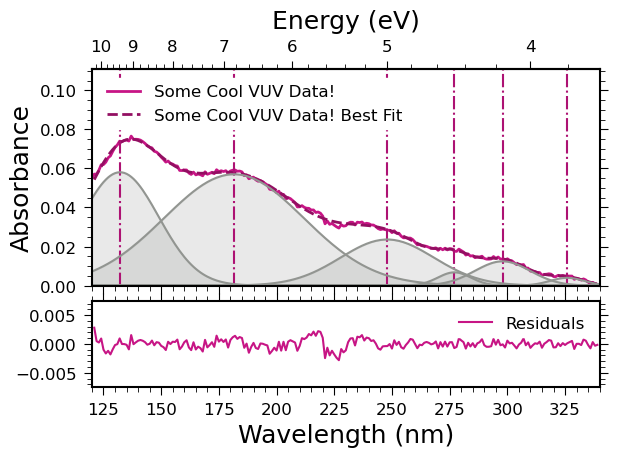

In [30]:
guesses = [{'lower':0, 'guess':4, 'upper':5},   # amplitude
           {'lower':0, 'guess':135, 'upper':340},   # center
           {'lower':0, 'guess':20, 'upper':340},   # standard deviation
           
           {'lower':0, 'guess':3, 'upper':5},   # amplitude
           {'lower':0, 'guess':185, 'upper':340},   # center
           {'lower':0, 'guess':20, 'upper':340},   # standard deviation
           
           {'lower':0, 'guess':2, 'upper':5},   # amplitude
           {'lower':225, 'guess':240, 'upper':250},   # center
           {'lower':0, 'guess':20, 'upper':340},   # standard deviation
           
           {'lower':0, 'guess':0.4, 'upper':5},   # amplitude
           {'lower':274, 'guess':276, 'upper':279},   # center
           {'lower':0, 'guess':20, 'upper':100},   # standard deviation
           
           {'lower':0, 'guess':0.4, 'upper':5},   # amplitude
           {'lower':296, 'guess':298, 'upper':300},   # center
           {'lower':0, 'guess':20, 'upper':100},   # standard deviation
           
           {'lower':0, 'guess':0.1, 'upper':5},   # amplitude
           {'lower':324, 'guess':326, 'upper':328},   # center
           {'lower':0, 'guess':10, 'upper':100},   # standard deviation
          ]

spec.fit_peaks(verbose=True, ng=6, guesses=guesses, fit_lim=(120, 340))
specTools.plot_fit(spec, plot_peaks=True, xlim=(120, 340),
               ylim=(0, spec.data[spec.data['wavelength']>120]['absorbance'].max()*1.1),
               plot_fit_components=True, save_path="./misc_figures/fit.svg")

In [31]:
spec.data

,wavelength,absorbance,offset absorbance,best_fit,residuals
0,110.0,0.036513,0.012398,NaN,NaN
1,111.0,-0.002350,-0.026466,NaN,NaN
2,112.0,0.022638,-0.001477,NaN,NaN
3,113.0,0.014045,-0.010071,NaN,NaN
4,114.0,0.096445,0.072330,NaN,NaN
...,...,...,...,...,...
226,336.0,0.024983,0.000868,0.025747,-0.000763
227,337.0,0.025773,0.001658,0.025454,0.000320
228,338.0,0.024884,0.000769,0.025194,-0.000310
229,339.0,0.024810,0.000694,0.024970,-0.000160


In [32]:
spec.peaks

[{'peak': 132.1611741407202, 'peak_error': 0.2731847265698752},
 {'peak': 181.52690419394142, 'peak_error': 0.690605496749274},
 {'peak': 247.94058589114866, 'peak_error': 0.9162816149944981},
 {'peak': 277.0422034374177, 'peak_error': 1.2625762611669944},
 {'peak': 297.91489391664334, 'peak_error': 1.3225031759728159},
 {'peak': 325.87360811741803, 'peak_error': 1.597896711501519}]

In [33]:
spec.fit_results

{'reduced_chi_square': 0.5103144021863664,
 'n_gaussians': 6,
 'n_custom_components': 0,
 'fitted_scattering': False,
 'custom_component_parameters': [],
 'scattering_parameters': [],
 'gaussian_parameters': [{'value': 2.442799062655488,
   'error': 0.17661897692225761,
   'parameter': 'amplitude'},
  {'value': 132.1611741407202,
   'error': 0.2731847265698752,
   'parameter': 'center'},
  {'value': 16.781369569150726,
   'error': 0.44411473860083905,
   'parameter': 'std'},
  {'value': 4.32676377266341,
   'error': 0.27031895450146226,
   'parameter': 'amplitude'},
  {'value': 181.52690419394142,
   'error': 0.690605496749274,
   'parameter': 'center'},
  {'value': 30.273467516154355,
   'error': 1.7714852550209894,
   'parameter': 'std'},
  {'value': 1.1974241901062608,
   'error': 0.13804794018989236,
   'parameter': 'amplitude'},
  {'value': 247.94058589114866,
   'error': 0.9162816149944981,
   'parameter': 'center'},
  {'value': 20.23187485980927, 'error': 1.373568495050898, 'par

In [34]:
spec.fit_components

[{'parameters': [{'value': 2.442799062655488,
    'error': 0.17661897692225761,
    'parameter': 'amplitude'},
   {'value': 132.1611741407202,
    'error': 0.2731847265698752,
    'parameter': 'center'},
   {'value': 16.781369569150726,
    'error': 0.44411473860083905,
    'parameter': 'std'}],
  'wavelength': 0      110.0
  1      111.0
  2      112.0
  3      113.0
  4      114.0
         ...  
  226    336.0
  227    337.0
  228    338.0
  229    339.0
  230    340.0
  Name: wavelength, Length: 231, dtype: float64,
  'absorbance': 0      2.428171e-02
  1      2.622312e-02
  2      2.821936e-02
  3      3.025993e-02
  4      3.233303e-02
             ...     
  226    5.313555e-34
  227    2.571947e-34
  228    1.240499e-34
  229    5.961960e-35
  230    2.855218e-35
  Name: wavelength, Length: 231, dtype: float64},
 {'parameters': [{'value': 4.32676377266341,
    'error': 0.27031895450146226,
    'parameter': 'amplitude'},
   {'value': 181.52690419394142,
    'error': 0.69060549674

**IMPORTANT!!** The fitting is done to the data **with the spectrum offset applied**. The justification for this is that you make your nice plot, and then likely want to fit that which you see in front of you, rather than unadjusted data. Any negative absorbance regions in unadjusted data can also give strange looking fits when then converted to offset adjusted data for plotting.

Because of this, the `fit_results` will show your fit components **with** the spectrum offset used when fitting. If you do not want this, remember to subtract it out again! Or, set the spectrum offset to 0 before fitting.

Based on user feedback, this may change in future versions.

## Example: Fitting with whatever you want

DUVET also lets you fit with other things than Gaussian functions. For this you can set the `custom_components` parameter in the `fit_peaks` function. The value of `custom_components` should be a list of pandas dataframes, each with at least a wavelength column labelled "wavelength" and an absorbance column labeled "absorbance". They can use any wavelength range, and the wavelength resolution does not have to match your data as DUVET can interpolate.

Let's say that for fun instead of using just the Gaussian functions in the example above, I also decide I want to include a pre-calculated linear function into the fit. I can make my custom component and add it in as shown below:

In [35]:
# make x values for the custom component
X = np.linspace(120, 340, 300)
# make y values for the custom component
Y = [(-0.045/50)*x +0.3 for x in X]

# add the values to a dictionary, then make the dataframe
custom_dict = {
    "wavelength":X,
    "absorbance":Y
}
custom_df = pd.DataFrame(custom_dict)


In [36]:
custom_df

,wavelength,absorbance
0,120.000000,0.192000
1,120.735786,0.191338
2,121.471572,0.190676
3,122.207358,0.190013
4,122.943144,0.189351
...,...,...
295,337.056856,-0.003351
296,337.792642,-0.004013
297,338.528428,-0.004676
298,339.264214,-0.005338


Now we have a dataframe with some absorbance values at various wavelengths. Let's use it in a fit:

(<Axes: ylabel='Absorbance'>, <Axes: xlabel='Wavelength (nm)'>)

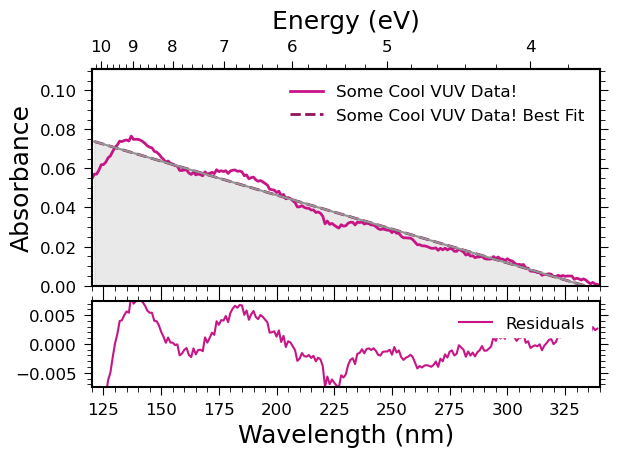

In [37]:
guesses = [{'lower':0, 'guess':1, 'upper':10}, # amplitude of our custom component
    ]

spec.fit_peaks(verbose=True, ng=0, guesses=guesses, fit_lim=(120, 340),
              custom_components=[custom_df])
specTools.plot_fit(spec, plot_peaks=True, xlim=(120, 340),
               ylim=(0, spec.data[spec.data['wavelength']>120]['absorbance'].max()*1.1),
               plot_fit_components=True, save_path="./misc_figures/fit.svg")

In [38]:
spec.fit_components

[{'parameters': {'value': 0.38634186438109736, 'error': 0.0024388864262753756},
  'wavelength': 11     121.0
  12     122.0
  13     123.0
  14     124.0
  15     125.0
         ...  
  225    335.0
  226    336.0
  227    337.0
  228    338.0
  229    339.0
  Name: wavelength, Length: 219, dtype: float64,
  'absorbance': [0.07382993028322771,
   0.07348222260528471,
   0.07313451492734173,
   0.07278680724939873,
   0.07243909957145575,
   0.07209139189351277,
   0.07174368421556977,
   0.07139597653762679,
   0.0710482688596838,
   0.07070056118174081,
   0.07035285350379782,
   0.07000514582585485,
   0.06965743814791185,
   0.06930973046996887,
   0.06896202279202589,
   0.06861431511408288,
   0.0682666074361399,
   0.06791889975819691,
   0.06757119208025393,
   0.06722348440231093,
   0.06687577672436795,
   0.06652806904642496,
   0.06618036136848197,
   0.06583265369053899,
   0.065484946012596,
   0.06513723833465301,
   0.06478953065671002,
   0.06444182297876704,
   0.06409

As we can see from the residuals, fitting just a line to these data is not the best we could have possibly done. But, if you want to add in your own data to fit with, DUVET can handle it! In this example we created data in the form of a line, but you could just as easily have data from another experiment that you want to use. Just make sure that you format it in terms of wavelength and absorbance, and put it into a pandas dataframe. After that, DUVET doesn't care what the values are.

Once again, we can look at our `fit_results` to extract our amplitude on the custom component we fit with.

In [39]:
spec.fit_results

{'reduced_chi_square': 9.9562089317253,
 'n_gaussians': 0,
 'n_custom_components': 1,
 'fitted_scattering': False,
 'custom_component_parameters': [{'value': 0.38634186438109736,
   'error': 0.0024388864262753756}],
 'scattering_parameters': [],
 'gaussian_parameters': [],
 'p': array([0.38634186]),
 'pcov': array([[5.948167e-06]])}

In [40]:
spec.offset

-0.024115221965496998

In [41]:
spec.fit_components

[{'parameters': {'value': 0.38634186438109736, 'error': 0.0024388864262753756},
  'wavelength': 11     121.0
  12     122.0
  13     123.0
  14     124.0
  15     125.0
         ...  
  225    335.0
  226    336.0
  227    337.0
  228    338.0
  229    339.0
  Name: wavelength, Length: 219, dtype: float64,
  'absorbance': [0.07382993028322771,
   0.07348222260528471,
   0.07313451492734173,
   0.07278680724939873,
   0.07243909957145575,
   0.07209139189351277,
   0.07174368421556977,
   0.07139597653762679,
   0.0710482688596838,
   0.07070056118174081,
   0.07035285350379782,
   0.07000514582585485,
   0.06965743814791185,
   0.06930973046996887,
   0.06896202279202589,
   0.06861431511408288,
   0.0682666074361399,
   0.06791889975819691,
   0.06757119208025393,
   0.06722348440231093,
   0.06687577672436795,
   0.06652806904642496,
   0.06618036136848197,
   0.06583265369053899,
   0.065484946012596,
   0.06513723833465301,
   0.06478953065671002,
   0.06444182297876704,
   0.06409

## Fitting Organization

When you provide guesses, it is important to do so in the right order. DUVET does not know what number you want to use as an amplitude, or standard deviation, or whatever else, but expects these values to come in a specific order. The order is: custom component amplitudes, Rayleigh scattering parameters, and Gaussian function parameters.

The example list of guesses below shows the expected order of guesses for a fit using two custom components, Rayleigh scattering correction, and three Gaussians:

In [42]:
guesses = [# custom component parameters come first
           {'lower':0, 'guess':4, 'upper':5},   # amplitude
           {'lower':0, 'guess':2, 'upper':3},   # amplitude

           # Rayleigh scattering parameters are second
           {'lower':0, 'guess':4, 'upper':5},   # m
           {'lower':0, 'guess':4, 'upper':5},   # k
           {'lower':0, 'guess':4, 'upper':5},   # b

           # Gaussian parameters come last, grouped in threes
           {'lower':0, 'guess':4, 'upper':5},   # amplitude
           {'lower':0, 'guess':135, 'upper':340},   # center
           {'lower':0, 'guess':20, 'upper':340},   # standard deviation
           
           {'lower':0, 'guess':3, 'upper':5},   # amplitude
           {'lower':0, 'guess':185, 'upper':340},   # center
           {'lower':0, 'guess':20, 'upper':340},   # standard deviation
           
           {'lower':0, 'guess':2, 'upper':5},   # amplitude
           {'lower':225, 'guess':240, 'upper':250},   # center
           {'lower':0, 'guess':20, 'upper':340},   # standard deviation
          ]

DUVET organizes your guesses by first checking how many custom components you have provided to the fit function, labelling that number as $n$, and taking that many of the dictionaries in the list of guesses as the guesses on the custom component amplitudes. It then checks if you have enabled scattering fitting or not. If yes, it will take the next three dictionaries in the list of guesses as the guesses on the Rayleigh scattering parameters. It then takes the rest of the provided dictionaries in the guesses list as the guesses on the Gaussian components, if any. It groups those into threes, each with an amplitude, a center, and a standard deviation in that order.

If you do not provide guesses in the expected order, you may get a different fit function than you want, or the fit may not work at all.

## Difference in Plotting Functions

DUVET includes two plotting functions: `plot_absorbance` and `plot_fit`. They serve different purposes.

`plot_absorbance` takes a list of `Spectrum` or `StitchedSpectrum` objects and plots their absorbance vs wavelength. It is good for plotting several spectra which you wish to compare.

`plot_fit` takes a single `Spectrum` or `StitchedSpectrum` object and plots the fit which has been made to its absorbance, if any such fit has been made. It is good for seeing the components which went into the fit.

The plotting functions take similar, but different parameters. I recommend running the `help()` funciton on them to see the full list of parameters they take, and how they can be customized.

Remember also that DUVET preserves all of the data associated with your spectra as attributes of the `Spectrum` or `SitchedSpectrum` objects you have created. You can always access these attributes (see examples above), take the data, and plot them yourself if you have your own preferred plot style, or need to take additional analysis steps.

# Deposition Time Scans

Spectra are not the only data taken at the UV endstation. It is also necessary to monitor the deposition of an ice with the deposition time scans. These can then be fit, and optics principles can be used to determine the dosing rate and index of refraction of the ice. This is done using `depTools.py`, for deposition tools.

In [43]:
import depTools

`depTools` has only one class: `DepositionTimeScan`. It is initialized by giving it the data file of some deposition time scan. The data can then be plotted with `plot_timescan()`

<Axes: xlabel='Time (seconds)', ylabel='Ch2 Signal (volts)'>

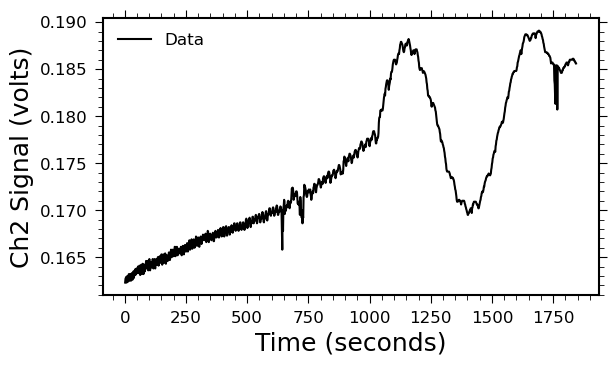

In [44]:
# create the DepositionTimeScan object
path = "./raw_data/SergioIoppolo-November2023/20231101/T73776.dat"
dep = depTools.DepositionTimeScan(path)

# plot it
depTools.plot_timescan(dep, save_path="./misc_figures/deposition_fit.svg")

Finding the dosing rate is then (in principle) very easy. All you need to do is run `find_dosing_rate()` and give the function a few parameters, all of which are optional for the function itself, but likely necessary to get a good fit.

The first of these is `guesses` which contains the guesses for the fitted parameters. It is structured the same way as the guesses for spectrum fitting. It should be a list where each item in the list is a dictionary containing a lower and upper limit on the parameter, and a guess. There are five parameters that are fit every time. These parameters are called `m`, `c`, `xc`, `w`, and `n`. The function being fit with these parameters is shown below:

$$
f\left(x\right) = mx + c + \left(c\frac{n-1}{n+1}\right)\sin\left(\frac{x-x_c}{w}\right)
$$

The function is the combination of a line and a sine wave. Parameters `m` and `c` describe the slope and y-intercept of the line component respectively. Parameter `n` describes the index of refraction of the deposited ice, parameter `xc` describes the x-shift $x_c$, and parameter `w` describes the 'wavelength' of the sine wave (note that the wavelength in this function has units of time). Note that the expression $\left(c\frac{n-1}{n+1}\right)$ is a constant that describes the amplitude of the sine wave. The function is not fit directly to the raw data, but rather to gaussian smoothed data. This helps avoid broken fits when the time range is small.

The next important parameters are `t_start` and `t_end` which are the start and end times of the deposition in seconds. As seen in the example file above, the entire file does not represent the deposition. In the example, the deposition starts at roughly 1020 seconds and ends at roughly 1700 seconds. Trying to use the above function to fit any of the data outside that range will either break or give a nonsense result, so these parameters are very important and should not be omitted.

The next parameter is `theta_degrees` which describes in degrees the angle of incidence between the laser and the substrate. By default this is 22 and should not be changed unless the physical setup of the chamber has been changed.

Finally, there is the parameter `verbose`, which can be true or false. If true, the function will print extra statements with the values of the fitted parameters.


The fit suceeded with a reduced chi square of 9.551e-05
The deposition rate is 0.586 +- 0.001 nm/s
The ice's index of refraction is 1.108 +- 0.000
The other fitted values are:
'm' : 0.000 +- 0.000
'c' : 0.175 +- 0.000
'tc' : 505.946 +- 0.674
'w' : 258.601 +- 0.213


<Axes: xlabel='Time (seconds)', ylabel='Ch2 Signal (volts)'>

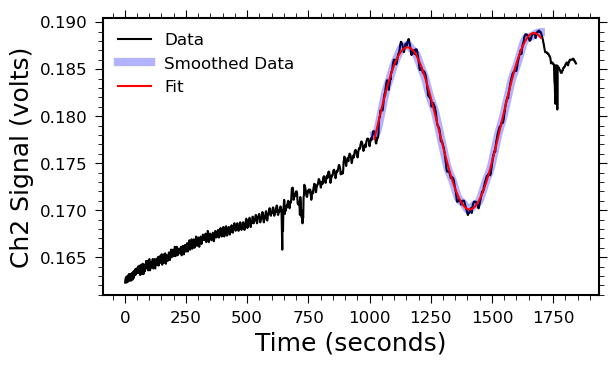

In [45]:
# importing numpy so we can set the limits on the parameters to infinity
import numpy as np

# setup our guesses. These are the same as the default guesses if none are provided
guesses = [{'lower':-np.inf, 'guess':3e-6, 'upper':np.inf}, # m
           {'lower':-np.inf, 'guess':0, 'upper':np.inf}, # c
           {'lower':-np.inf, 'guess':200, 'upper':np.inf}, # xc
           {'lower':0, 'guess':300, 'upper':np.inf}, # w
           {'lower':1, 'guess':1.2, 'upper':4.1} # n
            ]

# fit the data and get the dosing rate
dep.find_deposition_rate(guesses=guesses, t_start=1020, t_end=1700, verbose=True)
depTools.plot_timescan(dep, save_path="./misc_figures/deposition_fit.svg")

Now that you have the deposition rate, you can easily find out how much ice was deposited over some given time. This is just multiplying the rate by the deposition time, but there is a built in function to do this for you and handle the associated error more conveniently than by hand. This function is `find_thickness` and takes two parameters. The first is `dep_time`, the deposition time in seconds, and the second is `verbose`, whether or not to print extra statements. The function returns the deposited ice thickness in nanometers as well as its error.

In [46]:
thickness, error = dep.find_thickness(dep_time=680, verbose=True)

The ice deposited for 680 seconds will be 398.747 +- 0.561 nm thick.


That is a very thick ice. In our experiments, we only wanted an ice of around 10 nm thick. The timescan above was taken just in order to measure the deposition rate, not actually do the deposition. When we deposited the ice we experimented on, we only deposited for 20 seconds.

In [47]:
thickness, error = dep.find_thickness(dep_time=20, verbose=True)

The ice deposited for 20 seconds will be 11.728 +- 0.017 nm thick.


This gave roughly the desired thickness, as we can see here. But why not just fit the deposition scan of the ice we actually used? A deposition time of only 20 seconds is far too short to generate a fittable sine curve like the one above. Further, the user might not yet know how long they want to deposit for, only how thick of an ice they want to eventually have. The deposition rate must be found first. This is also why the program does not automatically calculate the thickness of the deposited ice when you run `find_deposition_rate()`.

But what about that user who knows what thickness of ice they want, but not how long to deposit for? `depTools` can also calculate that in much the same way as finding the thickness:

In [48]:
time, error = dep.find_deposition_time(thickness=10, verbose=True)

The ice deposited to 10 nm will take 17.053 +- 0.024 seconds.


Finally, what about exporting all of these parameters? That is easily done with the `export` function, which will save the fitted parameters to a csv file at a specified path:

In [49]:
dep.export("./misc_figures/deposition_fit.csv")

if we now read that csv file we will see:

In [50]:
import pandas as pd

df = pd.read_csv("./misc_figures/deposition_fit.csv")
df

,name,value,error
0,m,0.000003,6.056960e-08
1,c,0.174932,8.114540e-05
2,tc,505.945931,6.737161e-01
3,w,258.601084,2.134565e-01
4,n,1.108467,1.723485e-04
5,deposition rate (nm/s),0.586392,8.254277e-04
6,refractive index,1.108467,1.723485e-04
7,redchi2,0.000096,NaN
